# RipsNet - tutorial

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" # need this to use ragged=True in the input.

import gudhi as gd
import numpy as np
from tqdm import tqdm 
import tensorflow as tf
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from gudhi.representations import DiagramSelector
from gudhi.representations import Landscape, PersistenceImage

import keras
from src.data.utils.create_circles import create_multiple_circles

# attention if problems between keras and tensorflow, use the following pip install tf_keras
from src.arxiv.utils import DenseRagged, PermopRagged

2024-11-06 11:04:18.143504: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 11:04:18.160455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730887458.181169  207591 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730887458.187394  207591 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 11:04:18.208173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Ripsnet
In this tutorial, we show how to use RipsNet to learn the topology of very simple synthetic data sets comprised of (noisy) circles. Let's first define the seed (for reproducibility), the number of point clouds that we will use for training RipsNet, the number of point clouds we will use to test it, the cardinality of the point clouds and finally the amount of corrupted points (when noise is added).

In [2]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points

# -- create dataset 
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=0, num_points_noise=N_noise)
clean_data_test, clean_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=0, num_points_noise=N_noise)
noisy_data_test, noisy_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=1, num_points_noise=N_noise)

# -- label encoder
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

Let's check some of these point clouds!

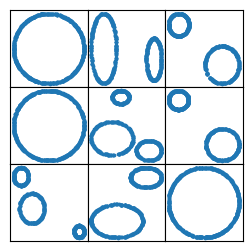

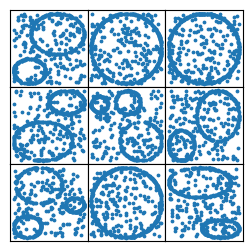

In [3]:
fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j][:,0], noisy_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])

Now, we can compute the persistence diagrams (in homology dimension 1) of the train, clean test and noisy test point clouds!

In [5]:
# -- max pairwise distance
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

print('Max pairwise distance:', maxd)

# -- Train persistence diagrams
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

# -- Test persistence diagrams
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)

# -- Noisy test persistence diagrams
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)


# -- Diagram selector
PVs_train, clean_PVs_test, noisy_PVs_test, PVs_params = [], [], [], []
pds_train      = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

# -- Hparams for featu
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

print('Persistence diagram parameters:', "sigma", sigma, "im_bnds", im_bnds, sp_bnds)

# -- PI features
PI_params = {'bandwidth': sigma, 
             'weight': lambda x: 10*np.tanh(x[1]), 
             'resolution': [50,50], 
             'im_range': im_bnds
             }
PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
clean_PI_test = PersistenceImage(**PI_params).fit_transform(clean_pds_test)
noisy_PI_test = PersistenceImage(**PI_params).fit_transform(noisy_pds_test)
MPI = np.max(PI_train)
PI_train /= MPI
clean_PI_test /= MPI
noisy_PI_test /= MPI

# -- Landscape features
PL_params = {'num_landscapes': 5, 'resolution': 300, 'sample_range': sp_bnds}
PL_train = Landscape(**PL_params).fit_transform(pds_train)
clean_PL_test = Landscape(**PL_params).fit_transform(clean_pds_test)
noisy_PL_test = Landscape(**PL_params).fit_transform(noisy_pds_test)
MPL = np.max(PL_train)
PL_train /= MPL
clean_PL_test /= MPL
noisy_PL_test /= MPL

Max pairwise distance: 36.89927173087859


100%|██████████| 300/300 [00:02<00:00, 107.31it/s]


Persistence diagram parameters: sigma 5.000000000003381 im_bnds [0.0017808588093486746, 36.39290791045774, 4.440892098500626e-16, 24.955983849347543] [0.0017808588093486746, 36.39299857111378]


In [6]:
tf_data_train = tf.ragged.constant([
    [list(c) for c in list(data_train[i])] for i in range(len(data_train))], ragged_rank=1)
tf_clean_data_test = tf.ragged.constant([
    [list(c) for c in list(clean_data_test[i])] for i in range(len(clean_data_test))], ragged_rank=1)
tf_noisy_data_test = tf.ragged.constant([
    [list(c) for c in list(noisy_data_test[i])] for i in range(len(noisy_data_test))], ragged_rank=1)

W0000 00:00:1730816498.034563  176895 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Model definition

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=200, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)
optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)

# - define the model
inputs = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)
x = tf.keras.layers.Dense(50,  activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(x)
model_PI = tf.keras.Model(inputs=inputs, outputs=outputs)
model_PI.compile(optimizer=optim, loss="mse")

# - print the summary of the model
model_PI.summary()

# - fit the model
history = model_PI.fit(tf_data_train, PI_train, epochs=2, 
                       validation_data=(tf_clean_data_test, clean_PI_test), callbacks=[callback], verbose=0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 2)]         0         
                                                                 
 dense_ragged (DenseRagged)  (None, None, 30)          90        
                                                                 
 dense_ragged_1 (DenseRagge  (None, None, 20)          620       
 d)                                                              
                                                                 
 dense_ragged_2 (DenseRagge  (None, None, 10)          210       
 d)                                                              
                                                                 
 permop_ragged (PermopRagge  (None, 10)                0         
 d)                                                              
                                                             

Learning is done! The advantage of RipsNet is that we can now use it to predict persistence images directly from point clouds in the blink of an eye!

In [8]:
train_PI_prediction = model_PI.predict(tf_data_train)
clean_PI_prediction = model_PI.predict(tf_clean_data_test)
noisy_PI_prediction = model_PI.predict(tf_noisy_data_test)

10/10 [==============================] - 0s 6ms/step


Let's see how accurate the predictions of RipsNet really are, at least on the train set.

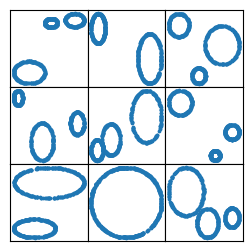

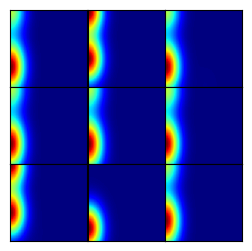

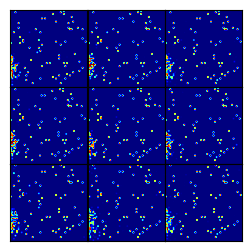

In [9]:
fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_clean_data_test[3*i+j,:,0], tf_clean_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_prediction[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

Pretty good actually! Let's look at the test set now.

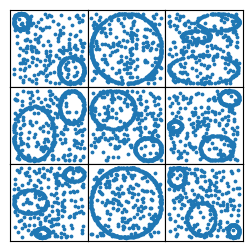

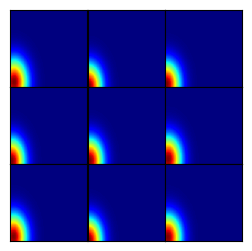

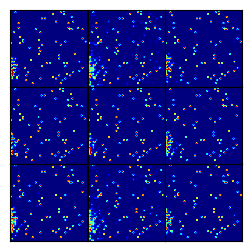

In [10]:
fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_noisy_data_test[3*i+j,:,0], tf_noisy_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(noisy_PI_test[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])


fig = plt.figure(figsize=(3, 3)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(noisy_PI_prediction[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()

Yep, even though Gudhi now produces bad images because of the ambiant noise, RipsNet predictions still look rather good. Another way to quantify this is to see the difference between classifiers predicting the number of circles that are trained either from Gudhi or from RipsNet predictions. Let's first see how an XGBoost model performs when using Gudhi descriptors.

In [13]:
# - on ground truth PI
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PI_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PI_test, clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PI_test, noisy_label_classif_test)

print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

# - on predicted PI
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PI_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PI_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PI_prediction, noisy_label_classif_test)

print("Accuracy on clean test set with predicted PI = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set with predicted PI = " + str(noisy_test_acc_RN))

/home/jmordacq/miniconda3/envs/tda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on clean test set = 0.9966666666666667
Accuracy on noisy test set = 0.3333333333333333


/home/jmordacq/miniconda3/envs/tda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on clean test set with predicted PI = 0.73
Accuracy on noisy test set with predicted PI = 0.7366666666666667


### With Persistence Landscapes
Now, let's play the same game with persistence landscapes, using the same architecture (except for the dimension of the final layer of course). In the three following cells, we define RipsNet, train it on landscapes, and use it to predict persistence landscapes from the data.

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=200, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)
optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)
x = tf.keras.layers.Dense(50,  activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
outputs = tf.keras.layers.Dense(PL_train.shape[1], activation='sigmoid')(x)
model_PL = tf.keras.Model(inputs=inputs, outputs=outputs)
model_PL.compile(optimizer=optim, loss="mse")

# - fit the model 
history = model_PL.fit(tf_data_train, PL_train, epochs=2, 
                       validation_data=(tf_clean_data_test, clean_PL_test), callbacks=[callback], verbose=0)

# - compute the predictions
train_PL_prediction = model_PL.predict(tf_data_train)
clean_PL_prediction = model_PL.predict(tf_clean_data_test)
noisy_PL_prediction = model_PL.predict(tf_noisy_data_test)

10/10 [==============================] - 0s 6ms/step


Let's see how good RipsNet is for landscapes now.

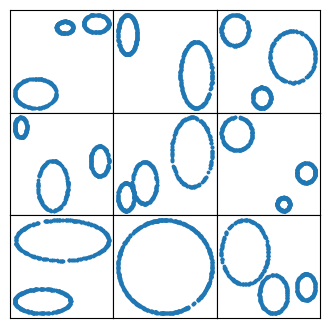

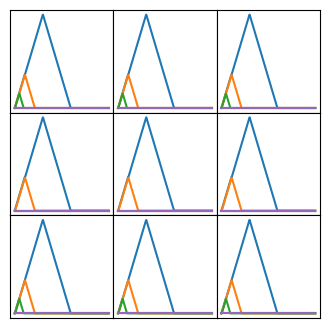

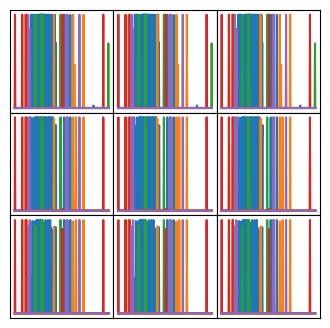

In [16]:
fig = plt.figure(figsize=(4, 4)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_clean_data_test[3*i+j,:,0], tf_clean_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(4, 4)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        for lidx in range(5):
            plt.plot(clean_PL_test[i][lidx*300:(lidx+1)*300]) 
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(4, 4)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        for lidx in range(5):
            plt.plot(clean_PL_prediction[i][lidx*300:(lidx+1)*300])
        plt.xticks([])
        plt.yticks([])

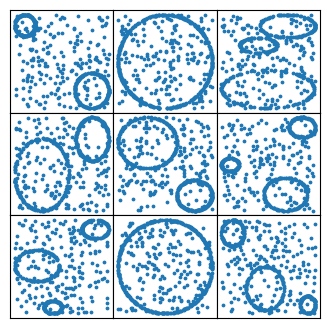

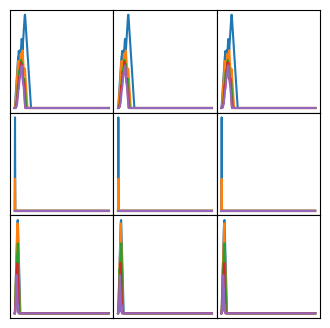

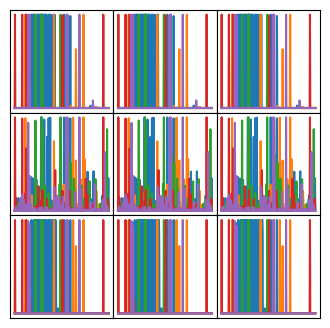

In [17]:
fig = plt.figure(figsize=(4, 4)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_noisy_data_test[3*i+j,:,0], tf_noisy_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(4, 4)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        for lidx in range(5):
            plt.plot(noisy_PL_test[i][lidx*300:(lidx+1)*300]) 
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(4, 4)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        for lidx in range(5):
            plt.plot(noisy_PL_prediction[i][lidx*300:(lidx+1)*300])
        plt.xticks([])
        plt.yticks([])

As before, we end by training XGBoost classifier on both Gudhi and RipsNet generated landscapes.

In [18]:
# - on ground truth PL
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PL_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PL_test,  clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PL_test,  noisy_label_classif_test)

print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

# - on predicted PL
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PL_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PL_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PL_prediction, noisy_label_classif_test)

print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

/home/jmordacq/miniconda3/envs/tda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on clean test set = 0.9966666666666667
Accuracy on noisy test set = 0.6666666666666666


/home/jmordacq/miniconda3/envs/tda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on clean test set = 0.77
Accuracy on noisy test set = 0.76
